In [2]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [3]:
from dataset_creation import dataset_creator as data_generator

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [4]:
# TEST Variables
agreeability_thresh=.2
manifest="indiv"
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean  = False

test_feats = ["const", "group_sizes"] 

In [5]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False
Total Groups in Analysis - 273


In [6]:
# Get groups sizes (for indiv and group)
group_sizes = data_generator.get_group_sizes_for_ids(reliable_ids, manifest)

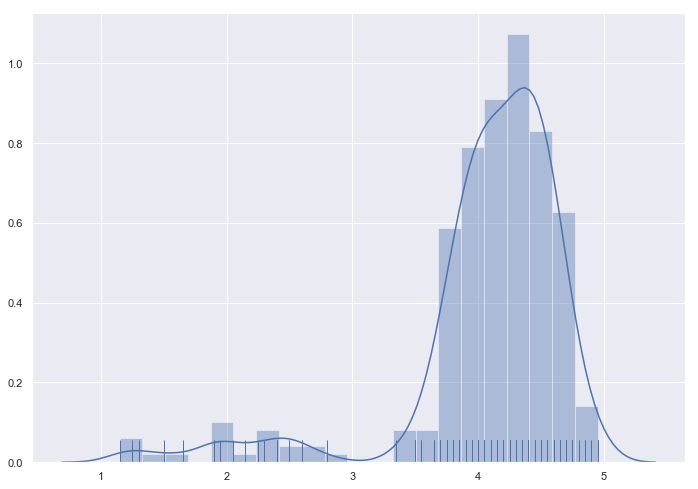

In [7]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

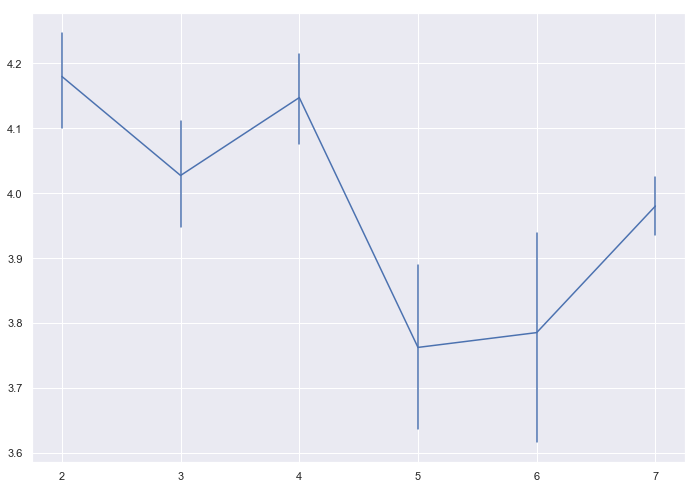

In [10]:
sns.lineplot(x=group_sizes, y=reliable_convqs, err_style="bars", ci=68)

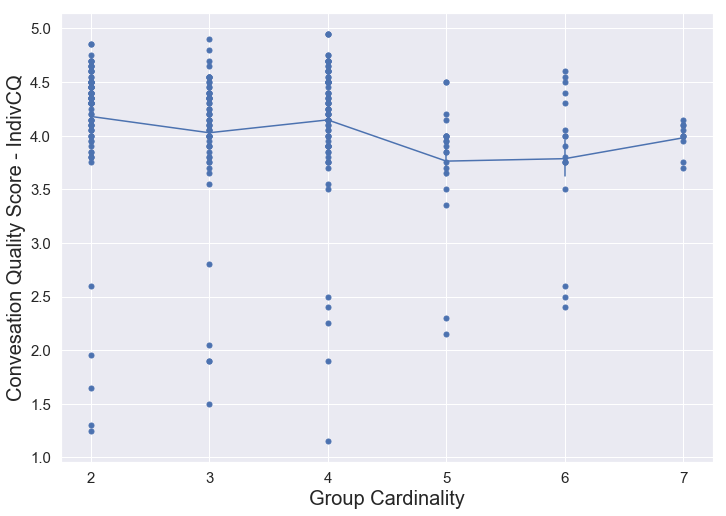

In [85]:
# Scatter Plot - Grp Size Vs ConvQ
plt.scatter(group_sizes, reliable_convqs,s=25,c='b')
sns.lineplot(x=group_sizes, y=reliable_convqs, err_style="bars", ci=68)
plt.ylabel('Convesation Quality Score - IndivCQ', fontsize=20)
plt.xlabel('Group Cardinality', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

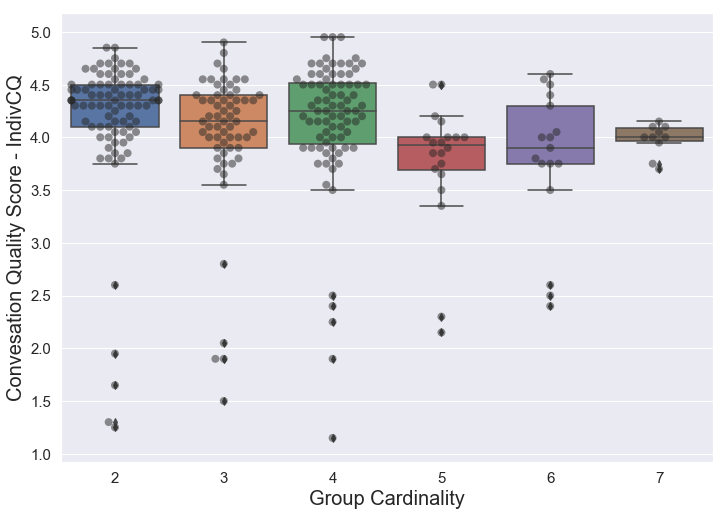

In [86]:
sns.boxplot(group_sizes, reliable_convqs)
sns.swarmplot(group_sizes, reliable_convqs,s=8, color=".15", alpha=0.5)
plt.ylabel('Convesation Quality Score - IndivCQ', fontsize=20)
plt.xlabel('Group Cardinality', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [13]:
# Dataset Prep
gs_X = pd.DataFrame(data=group_sizes, index=reliable_ids, columns=["group_sizes"]) 
gs_X["convq"] = reliable_convqs

In [73]:
# Experiment Below

# Statistical Test for: (Main Question)
# Does group-size have an effect on the Perceived Individual's Experience of Conversation Quality?
# 
# 1. Validate Significance @ p<0.05 using a Quantile Least Square based Regression (group_size Vs ConvQ)
# 2. Validate futher for Significance @ p<0.05 with pairs of group-sizes. (Pairwise Quantile LS Tests)
# 3. Check the co-efficients for relationships.

# Quantile Regression
X = sm.add_constant(gs_X)
# model = sm.GLM(X["convq"], X.loc[:,test_feats], family=sm.families.Gamma())
model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,test_feats])
# model = sm.OLS(X["convq"], X.loc[:,test_feats])


results = model.fit()
print(results.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.04787
Model:                       QuantReg   Bandwidth:                      0.2584
Method:                 Least Squares   Sparsity:                       0.9368
Date:                Mon, 01 Jun 2020   No. Observations:                  273
Time:                        16:40:01   Df Residuals:                      271
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5000      0.078     57.795      0.000       4.347       4.653
group_sizes    -0.0833      0.021     -3.978      0.000      -0.125      -0.042


In [87]:
# Pairwise Quantile Regression
unique_groups = np.unique(X.loc[:,"group_sizes"].values)
print("Total Number of Tests -> " + str(len(list(itertools.combinations(unique_groups,2)))))
for pair in list(itertools.combinations(unique_groups,2)):
    pairwise_X = X.loc[X["group_sizes"].isin(list(pair))]
#     model = sm.OLS(pairwise_X["convq"], pairwise_X.loc[:,test_feats])
    model = sm.regression.quantile_regression.QuantReg(pairwise_X["convq"], pairwise_X.loc[:,test_feats])
    results = model.fit(q=.5)
    print("Current Pair -> " + str(list(pair)))
    print(results.summary())

Total Number of Tests -> 15
Current Pair -> [2, 3]
                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.02158
Model:                       QuantReg   Bandwidth:                      0.3226
Method:                 Least Squares   Sparsity:                       0.8855
Date:                Wed, 03 Jun 2020   No. Observations:                  146
Time:                        12:50:28   Df Residuals:                      144
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.7500      0.183     25.909      0.000       4.388       5.112
group_sizes    -0.2000      0.074     -2.692      0.008      -0.347      -0.053
Current Pair -> [2, 4]
                         QuantReg Regression Results 

                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.01058
Model:                       QuantReg   Bandwidth:                      0.3818
Method:                 Least Squares   Sparsity:                       0.8696
Date:                Wed, 03 Jun 2020   No. Observations:                   27
Time:                        12:50:28   Df Residuals:                       25
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.3000      1.107      2.981      0.006       1.020       5.580
group_sizes     0.1000      0.173      0.577      0.569      -0.257       0.457
